In [1]:
import numpy as np
import pandas as pd
import os 
import glob
import sys

import math
import json
import scipy
import scipy.stats
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib
import pickle as pckl
from PIL import Image
import seaborn as sns

from model_analysis_folders import all_model_info
import urllib.request, json
from scipy.io import loadmat

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams.update({'font.size': 6})

from notebook_helpers import * 


In [2]:
models_to_evaluate = ["kell2018","cochresnet50",
                      "cochresnet50_l2_1_robust_waveform", "cochresnet50_l2_p5_robust_waveform", "cochresnet50_linf_p002_robust_waveform",
                      "cochresnet50_l2_1_random_step_waveform", "cochresnet50_linf_p002_random_step_waveform",
                      "kell2018_l2_1_robust_waveform", "kell2018_linf_p002_robust_waveform",
                      "kell2018_l2_1_random_step_waveform", "kell2018_linf_p002_random_step_waveform",
                      "cochresnet50_l2_1_robust_cochleagram", "cochresnet50_l2_p5_robust_cochleagram",
                      "cochresnet50_l2_1_random_step_cochleagram",
                      "kell2018_l2_1_robust_cochleagram", "kell2018_l2_p5_robust_cochleagram",
                      "kell2018_l2_1_random_step_cochleagram",
                     ]

# Set the colors for the models we are measuring. 
model_cmap = ["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

plot_color_idx = [0,3,
                10,11,12,
                10,12,
                1,2,
                1,2,
                10,11,
                10,
                1,2,
                1,
                ]


assert (len(np.unique(plot_color_idx)) <= len(model_cmap)), 'Not enough colors to plot all of the networks!'
model_cmap_dict = {m:model_cmap[plot_color_idx[m_idx]] for m_idx, m in enumerate(models_to_evaluate)}

# Set the line styles for the models we are measuring

plot_style = ['-','-',
              '-','-','-',
              ':',':',
              '-','-',
              ':',':',
              '--', '--',
              '-.', 
              '--', '--',
              '-.',]

model_style_dict = {m:plot_style[m_idx] for m_idx, m in enumerate(models_to_evaluate)}


plot_num = [0,0,
            1,1,1,
            1,1,
            2,2,
            2,2,
            3,3,
            3,
            4,4,
            4] 

network_network_folder = 'network_network_evaluations'

models_by_type = {'kell2018':'standard',
              'cochresnet50':'standard',
              'cochresnet50_l2_1_robust_waveform':'adv_trained_wav',
              'cochresnet50_l2_p5_robust_waveform':'adv_trained_wav',
              'cochresnet50_linf_p002_robust_waveform':'adv_trained_wav',                 
              "cochresnet50_l2_1_random_step_waveform":'rand_trained_wav',
              "cochresnet50_linf_p002_random_step_waveform":'rand_trained_wav',                  
              'kell2018_l2_1_robust_waveform':'adv_trained_wav',
              'kell2018_linf_p002_robust_waveform':'adv_trained_wav',                  
              "kell2018_l2_1_random_step_waveform":'rand_trained_wav',
              "kell2018_linf_p002_random_step_waveform":'rand_trained_wav',                  
              'cochresnet50_l2_1_robust_cochleagram':'adv_trained_coch',
              'cochresnet50_l2_p5_robust_cochleagram':'adv_trained_coch',                  
              'cochresnet50_l2_1_random_step_cochleagram':'rand_trained_coch',
              'kell2018_l2_1_robust_cochleagram':'adv_trained_coch',
              'kell2018_l2_p5_robust_cochleagram':'adv_trained_coch',                  
              'kell2018_l2_1_random_step_cochleagram':'rand_trained_coch',
             }

model_types = ['standard','adv_trained_wav','adv_trained_coch','rand_trained_wav','rand_trained_coch']


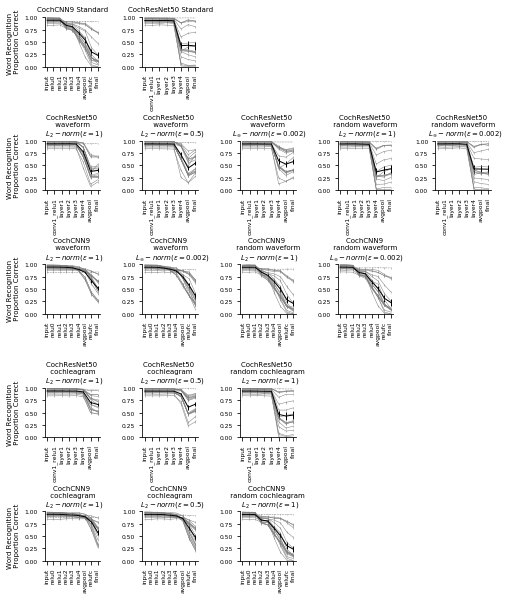

In [3]:
# Raw data -- all models. 

current_row = 0
subplot_idx=0
num_rows = 5
num_columns = 5
fig, axs = plt.subplots(num_rows, num_columns, figsize=(2*4,2*num_rows),
                        gridspec_kw={'hspace': 1.5, 'wspace': 0.75})

all_other_nets_evals = {}

# These will group together the MEASUREMENTS from a given model type. 
all_other_nets_evals_by_type = {}

for met_mod_idx, metamer_model in enumerate(models_to_evaluate): 
    all_other_nets_evals[metamer_model] = {}
    all_other_nets_evals_by_type[metamer_model] = {}
    metamer_model_layers = all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[metamer_model]['layers']
    model_name = all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[metamer_model]['paper_name']
    for layer in metamer_model_layers:
        all_other_nets_evals[metamer_model][layer] = []
        all_other_nets_evals_by_type[metamer_model][layer] = {m_type:[] for m_type in model_types}
    for measured_model in models_to_evaluate:
        measured_model_info = all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[measured_model]
        pckl_path = os.path.join(measured_model_info['location'], network_network_folder, 'accuracy_on_metamers_from_%s.pckl'%metamer_model)
        eval_pckl = pckl.load(open(pckl_path, 'rb'))
        # Store the data here. 
        for layer in metamer_model_layers:
            if measured_model!=metamer_model:
                all_other_nets_evals[metamer_model][layer].append(eval_pckl['average_correct'][layer])
                all_other_nets_evals_by_type[metamer_model][layer][models_by_type[measured_model]].append(eval_pckl['average_correct'][layer])
        if measured_model==metamer_model:
            this_plot_linestyle = '--'
        else:
            this_plot_linestyle = '-'
        axs[current_row, subplot_idx].errorbar(range(len(metamer_model_layers)), 
                 [eval_pckl['average_correct'][layer] for layer in metamer_model_layers],
                     yerr=[eval_pckl['bootstrap_sem'][layer] for layer in metamer_model_layers],
                 color='grey', 
                 linewidth=0.5,
                 ls=this_plot_linestyle) 
    # plot the average
    axs[current_row, subplot_idx].errorbar(range(len(metamer_model_layers)), 
             [np.mean(np.array(all_other_nets_evals[metamer_model][layer])) for layer in metamer_model_layers],
                 yerr=[np.std(np.array(all_other_nets_evals[metamer_model][layer]))/np.sqrt(len(all_other_nets_evals[metamer_model][layer])) for layer in metamer_model_layers],
             color='k', 
             linewidth=1,
             ls='-') 
    axs[current_row, subplot_idx].set_title(model_name, fontsize=7)
    axs[current_row, subplot_idx].set_ylim([0,1])
    if subplot_idx==0:
        axs[current_row, subplot_idx].set_ylabel('Word Recognition \n Proportion Correct', fontsize=7)
    axs[current_row, subplot_idx].set_xticks(range(len(metamer_model_layers)))
    axs[current_row, subplot_idx].set_xticklabels(labels=[layer.split('_fake_relu')[0].split('_fakerelu')[0].split('_after_preproc')[0] for layer in metamer_model_layers], rotation=90, fontsize=6)
    # Hide the right and top spines
    axs[current_row, subplot_idx].spines['right'].set_visible(False)
    axs[current_row, subplot_idx].spines['top'].set_visible(False)


    try:
        if plot_num[met_mod_idx+1]!=current_row:
            for k in range(subplot_idx+1,num_columns):
                axs[current_row,k].set_axis_off()
            current_row+=1
            subplot_idx=0
        else:
            subplot_idx+=1
    except IndexError:
        for k in range(subplot_idx+1,num_columns):
            axs[current_row,k].set_axis_off()
        continue
        
# plt.savefig('audio_model_model_comparisons_all_models_no_color.pdf')


# Visual Model-Human Recognizability Scatter Plot
# Figure 8F

In [4]:
experiment_list = [1,3,4,7,8] # do not compare Spectemp experiment

all_experiment_dictionaries = []

for exp_num in experiment_list:
    experiment_name = all_model_info.TURK_AUDIO_EXPERIMENTS_GROUPINGS['experiment_%d'%exp_num]['paper_experiment_name']
    jsin_configs = all_model_info.TURK_AUDIO_EXPERIMENTS_GROUPINGS['experiment_%d'%exp_num]['experiment_params_web']

    with urllib.request.urlopen(jsin_configs) as url:
        experiment_params = json.loads(url.read().decode())

    plot_model_order = experiment_params['experiment_info']['networks']
    
    exp_response_dict = {}
    for n_idx, network in enumerate(experiment_params['experiment_info']['networks']):
        participant_data_matrix, model_layers, conditions, participants = unpack_experiment_mat(
            '../AuditoryBehavioralExperiments/EXPERIMENT_%d/AudioExperiment%d_network_vs_humans_datamatrix_%s_public.mat'%(exp_num, exp_num, network))
        
        exp_response_dict[network] = responses_network_by_layer_mat(participant_data_matrix, model_layers, conditions, experiment_params)

    all_experiment_dictionaries.append(exp_response_dict)

combined_experiment_dict = combined_experiment_response_dictionaries(all_experiment_dictionaries)
   

R^2=0.949, p=0.000
rho=0.863, p=0.000
tau=0.713, p=0.000


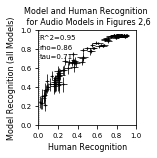

In [5]:
matplotlib.rcParams.update({'font.size': 7})

combined_human_means = []
combined_human_sem = []
combined_model_means = []
combined_model_sem = []

for model in combined_experiment_dict.keys():
    for layer in all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[model]['layers']:
        human_average = np.mean(combined_experiment_dict[model][layer])
        human_sem = np.std(combined_experiment_dict[model][layer])/np.sqrt(len(combined_experiment_dict[model][layer]))

        other_models_average = np.mean(all_other_nets_evals[model][layer])
        other_models_sem = np.std(all_other_nets_evals[model][layer])/np.sqrt(len(all_other_nets_evals[model][layer]))

        combined_human_means.append(human_average)
        combined_human_sem.append(human_sem)

        combined_model_means.append(other_models_average)
        combined_model_sem.append(other_models_sem)
    
plt.figure(figsize=(1.75,1.75))
plt.errorbar(combined_human_means, 
             combined_model_means,
             fmt='.',
             xerr=combined_human_sem,
             yerr=combined_model_sem,
             color='k',
             linewidth=0.75,
             markersize=2)
plt.plot([1/794,1/794],[0,1],':',color='grey', linewidth=0.75)
plt.plot([0,1],[1/793,1/793],':',color='grey', linewidth=0.75)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Human Recognition', fontsize=8)
plt.ylabel('Model Recognition (all Models)', fontsize=8)
plt.title('Model and Human Recognition \n for Audio Models in Figures 2,6', fontsize=8)

import scipy.stats
r_value, p_value = scipy.stats.pearsonr(combined_human_means, combined_model_means)
print('R^2=%0.3f, p=%0.3f'%(r_value**2, p_value))
plt.text(0.01,0.9,'R^2=%0.2f'%r_value**2, fontsize=7)

# Note: in our paper we just report the spearman correlation, but other stats are 
# included here for completeness (all are significant)
rho_value, p_value = scipy.stats.spearmanr(combined_human_means, combined_model_means)
print('rho=%0.3f, p=%0.3f'%(rho_value, p_value))
plt.text(0.01,0.8,'rho=%0.2f'%rho_value, fontsize=7)

tau_value, p_value = scipy.stats.kendalltau(combined_human_means, combined_model_means)
print('tau=%0.3f, p=%0.3f'%(tau_value, p_value))
plt.text(0.01,0.7,'tau=%0.2f'%tau_value, fontsize=7)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.savefig('ScatterModelHumanAudioModels_update_size.pdf')

# Change back for the other plots in this notebook
matplotlib.rcParams.update({'font.size': 6})



# Average CochResNet50 Plots
## Figure 8D

Text(0.5, 0, 'Metamer Generation Layer')

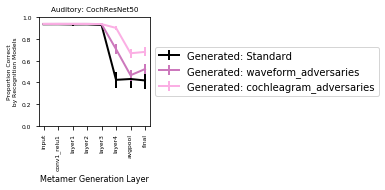

In [6]:
model_groupings = {'Generated: Standard':['cochresnet50'],
                   'Generated: waveform_adversaries':["cochresnet50_l2_1_robust_waveform", "cochresnet50_l2_p5_robust_waveform", "cochresnet50_linf_p002_robust_waveform",],
                   'Generated: cochleagram_adversaries':["cochresnet50_l2_1_robust_cochleagram", "cochresnet50_l2_p5_robust_cochleagram"],
                  }
cp = sns.color_palette("colorblind")
color_values = ['k', cp[4], cp[6]]
                   
    
plt.figure(figsize=(2,2))
all_group_data = {}
all_group_data_human = {}
all_group_data_recognition_averages = {}

for group_idx, metamer_group in enumerate(model_groupings.keys()):
    all_group_data[metamer_group] = {}
    all_group_data_human[metamer_group] = {}
    for met_mod_idx, metamer_model in enumerate(model_groupings[metamer_group]):
        all_group_data[metamer_group][metamer_model] = {}
        if (group_idx==0) and (met_mod_idx==0):
            metamer_model_layers = all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[metamer_model]['layers']
        else:
            # For this type of plot, the layers need to be *exactly* the same between the models. 
            assert metamer_model_layers == all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[metamer_model]['layers']
            
        all_group_data_human[metamer_group][metamer_model] = [np.mean(combined_experiment_dict[metamer_model][layer]) for layer in metamer_model_layers]
        
        for measured_model in models_to_evaluate:
            if measured_model != metamer_model:
                measured_model_info = all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO[measured_model]
                pckl_path = os.path.join(measured_model_info['location'], network_network_folder, 'accuracy_on_metamers_from_%s.pckl'%metamer_model)
                eval_pckl = pckl.load(open(pckl_path, 'rb'))
                average_correct = [eval_pckl['average_correct'][layer] for layer in metamer_model_layers]
                # Save the average group data. We will do the plotting afterwards. 
                all_group_data[metamer_group][metamer_model][measured_model] = average_correct

    # First average across the metamer generation models
    average_data_from_group = {}
    for measured_model in models_to_evaluate:
        collapse_data = []
        collapse_data_human = []
        for metamer_model in model_groupings[metamer_group]:
            if measured_model != metamer_model:
                collapse_data.append(all_group_data[metamer_group][metamer_model][measured_model])
        if len(model_groupings[metamer_group])>1:
            average_data_from_group[measured_model] = np.mean(np.array(collapse_data),0)
        else:
            if measured_model == model_groupings[metamer_group][0]:
                average_data_from_group[measured_model] = np.ones((len(metamer_model_layers)))*np.nan
            else:
                average_data_from_group[measured_model] = np.squeeze(np.array(collapse_data))
                
    collapse_group_human_data = []
    for metamer_model in model_groupings[metamer_group]:
        collapse_data.append(all_group_data_human[metamer_group][metamer_model])
    if len(model_groupings[metamer_group])>1:
        average_data_from_group_human_data = np.mean(collapse_data)
    else: 
        average_data_from_group_human_data = np.squeeze(collapse_data)
    
    all_group_data_recognition_averages[metamer_group] = average_data_from_group
    
    average_over_all_measured_models = np.squeeze(np.nanmean(np.array([average_data_from_group[measured_model] for measured_model in average_data_from_group.keys()]),0))
    sem_over_all_measured_models = np.squeeze(np.nanstd(np.array([average_data_from_group[measured_model] for measured_model in average_data_from_group.keys()]),0)/np.sqrt(len(models_to_evaluate)-1)) # N-1 because we don't use the same model for predictions
    plt.errorbar(range(len(metamer_model_layers)),
                 average_over_all_measured_models, 
                 yerr=sem_over_all_measured_models,
                 linewidth=2,
                 label=metamer_group,
                 color = color_values[group_idx]
                 )
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.title('Auditory: CochResNet50')
plt.ylim([0,1])
plt.ylabel('Proportion Correct\n by Recognition Models')

layer_labels = [layer.split('_fake_relu')[0].split('_fakerelu')[0].split('_after_preproc')[0] for layer in metamer_model_layers]
plt.xticks(range(len(layer_labels)), layer_labels, rotation=90)
plt.xlabel('Metamer Generation Layer', fontsize=8)             

# plt.savefig('2023_07_17_CochResNet50HumanRecModelGroupings.pdf')

